# PROJECT
# Development of a machine learning model to predict the cost of a used car

##Formulation of the problem

The customer, the service for selling used cars “Not a Bit, Not a Paint,” is developing an application to attract new customers.

There you can **quickly** find out the market value of your car.

Based on historical data (technical characteristics, configurations and prices of cars), it is necessary to build a machine learning model (solve a regression problem, supervised learning) to predict the market value of cars of application users.

The following are important to the customer:
- prediction quality (must be determined by the RMSE metric, the value of which should be less than 2,500);
- prediction speed;
- studying time.

Composition of historical data:

**Features**
- DateCrawled — date the profile was downloaded from the database
- VehicleType - car body type
- RegistrationYear—year of vehicle registration
- Gearbox - gearbox type
- Power - power (hp)
- Model - car model
- Kilometer - mileage (km)
- RegistrationMonth—month of vehicle registration
- FuelType - fuel type
- Brand - car brand
- Repaired - whether the car was repaired or not
- DateCreated — date of creation of the profile
- NumberOfPictures — number of photos of the car
- PostalCode — postal code of the profile owner (user)
- LastSeen — date of the user’s last activity

**Target feature**
- Price — price (euros)

## Data preparation

In [ ]:
import lightgbm as lgb
import numpy    as np
import pandas   as pd
import seaborn  as sns
from matplotlib import pyplot as plt

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.compose._column_transformer import _is_empty_column_selection

from sklearn.metrics import mean_squared_error as mse

import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/datasets/autos.csv', parse_dates = ['DateCrawled', 'DateCreated', 'LastSeen'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Since the model must predict the price of a car based on data about its technical characteristics, we will remove all columns that do not relate to them.

Namely:

- DateCrawled — date the profile was downloaded from the database
- RegistrationMonth—month of vehicle registration
- DateCreated — date of creation of the profile
- NumberOfPictures — number of photos of the car
- PostalCode — postal code of the profile owner (user)
- LastSeen — date of the user’s last activity

In [ ]:
data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated',
         'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1, inplace=True)

Let's convert the columns to the "snake" register:

In [ ]:
data.columns = data.columns.str.lower()
data.rename(columns={'vehicletype':'vehicle_type', 'registrationyear':'registration_year',
                                                     'fueltype':'fuel_type'}, inplace=True)

In [ ]:
data.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


In columns:
-VehicleType
- Gearbox
-Model
- FuelType
-Repaired

gaps in data.

Let's process them as follows:

- gaps in the VehicleType, Gearbox, Model columns - affect the determination of vehicle characteristics - replace them with 'other';

- gaps in the FuelType column - do not critically affect the characteristics of the car - replace them with "N\A"

- let’s assume that the gaps in the Repaired column indicate that the car has not been repaired; replace them with “no”.

In [ ]:
data['fuel_type'] = data['fuel_type'].fillna('N\A')
data['repaired'] = data['repaired'].fillna('no')
data['vehicle_type'] = data['vehicle_type'].fillna('other')
data['gearbox'] = data['gearbox'].fillna('other')
data['model'] = data['model'].fillna('other')

data.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no
9,999,small,1998,manual,101,golf,150000,N\A,volkswagen,no


We will sequentially study the statistical characteristics of the data in the columns and exclude/correct (if possible) anomalous values (outliers).

Let's create a function to review the data in the column:

In [ ]:
def data_info (column):

    print(column.value_counts())
    print()
    print(column.describe())

    sns.set(rc={'figure.figsize':(12,6)})

    sns.boxplot(x=column)
    plt.show()

    sns.histplot(data=column, bins=100)
    plt.show()

### **PRICE column (target attribute)**

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64


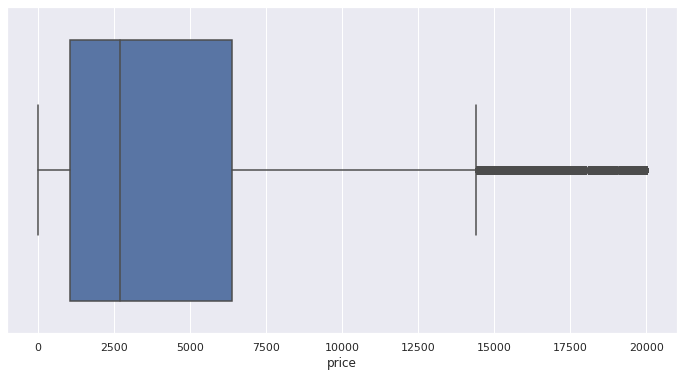

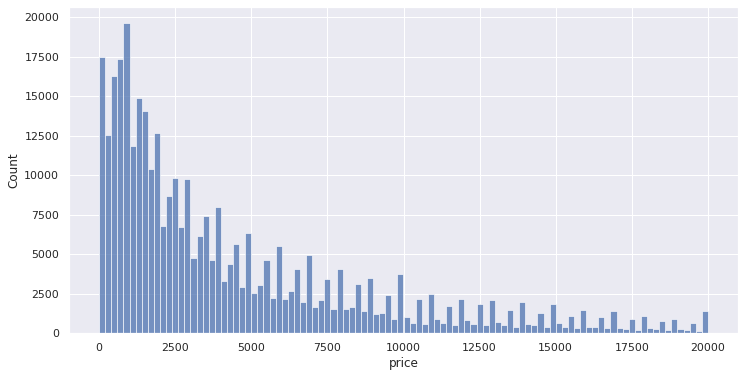

In [ ]:
data_info(data['price'])

We see that there are quite a lot of rows (10,772) with a zero price. Let's exclude them, as well as those where the price is less than the median / 5 (2700 / 5=540)

In [ ]:
data.drop(data.loc[data['price']<540].index, inplace=True)

1500    5394
1000    4649
1200    4594
2500    4438
600     3819
        ... 
4782       1
6575       1
8519       1
2221       1
8188       1
Name: price, Length: 3450, dtype: int64

count    312490.000000
mean       4976.999046
std        4521.830659
min         540.000000
25%        1500.000000
50%        3300.000000
75%        6999.000000
max       20000.000000
Name: price, dtype: float64


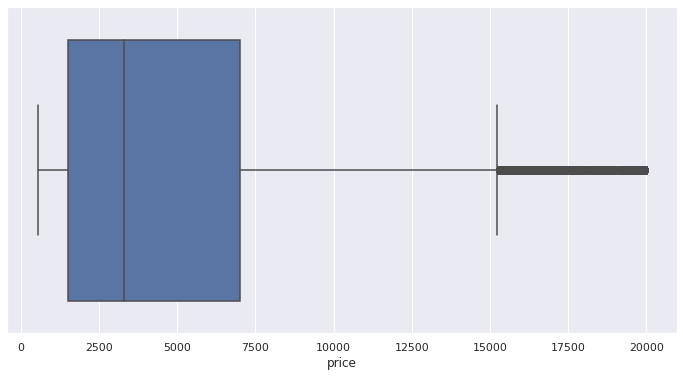

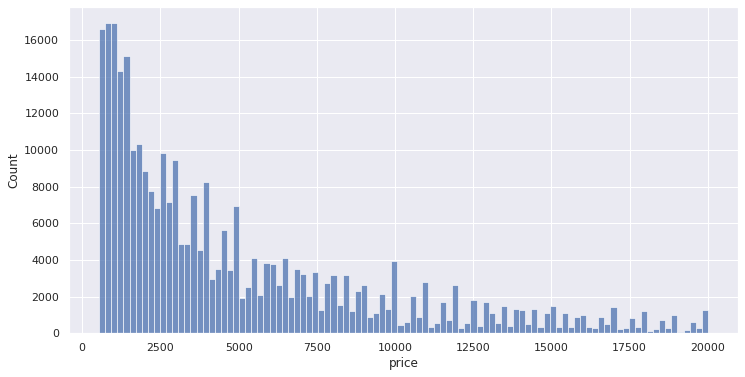

In [ ]:
data_info(data['price'])

### **Column VEHICLE_TYPE**

In [ ]:
data['vehicle_type'].value_counts()

sedan          84101
small          66261
wagon          59789
other          28924
bus            27645
convertible    19441
coupe          14643
suv            11686
Name: vehicle_type, dtype: int64

Category column. The data does not need to be processed.

### Column REGISTRATION_YEAR

2005    20982
2006    19599
2000    19244
2004    19183
2003    19159
        ...  
1949        1
5300        1
8888        1
7100        1
2290        1
Name: registration_year, Length: 127, dtype: int64

count    312490.000000
mean       2004.230654
std          64.346760
min        1000.000000
25%        2000.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


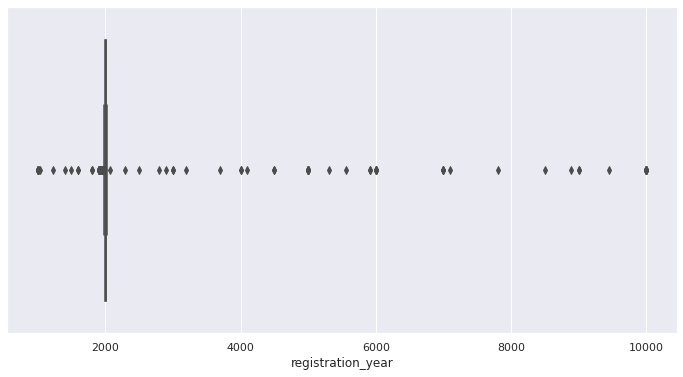

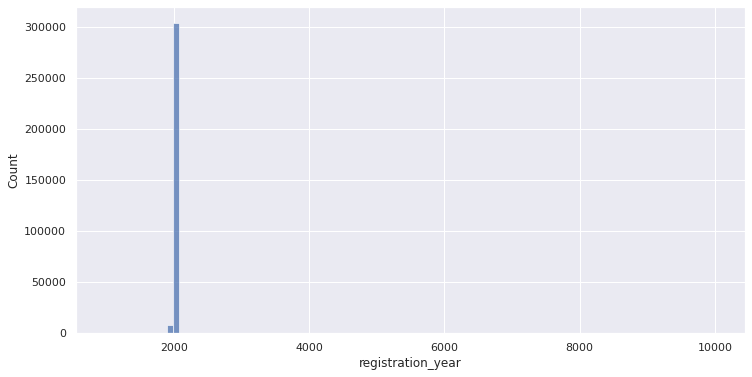

In [ ]:
data_info(data['registration_year'])

Let's exclude all rows whose year of registration does not fall within the range 1900 - 2023

In [ ]:
data.drop(data.loc[data['registration_year']>2023].index, inplace=True)
data.drop(data.loc[data['registration_year']<1900].index, inplace=True)

2005    20982
2006    19599
2000    19244
2004    19183
2003    19159
        ...  
1946        1
1931        1
1949        1
1927        1
1925        1
Name: registration_year, Length: 95, dtype: int64

count    312419.000000
mean       2003.572452
std           7.181944
min        1910.000000
25%        2000.000000
50%        2004.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64


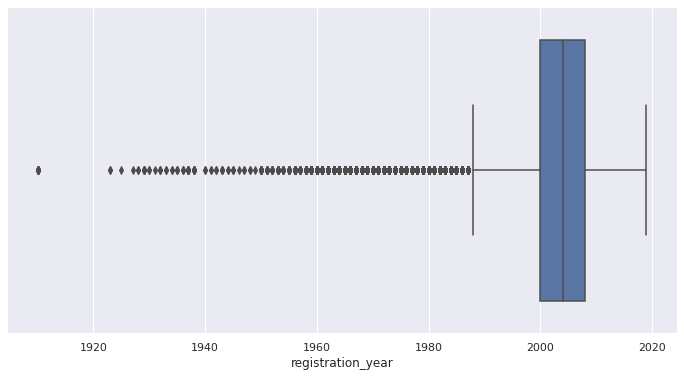

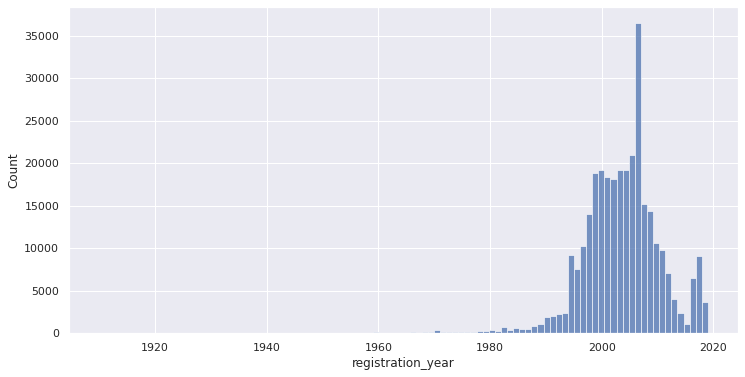

In [ ]:
data_info(data['registration_year'])

### Column GEARBOX

In [ ]:
data['gearbox'].value_counts()

manual    236696
auto       62906
other      12817
Name: gearbox, dtype: int64

Category column. The data does not need to be processed.

### Column POWER

0       27526
75      20080
150     13725
140     12542
101     12109
        ...  
9013        1
4400        1
1436        1
2461        1
6512        1
Name: power, Length: 663, dtype: int64

count    312419.000000
mean        115.671652
std         188.936247
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: power, dtype: float64


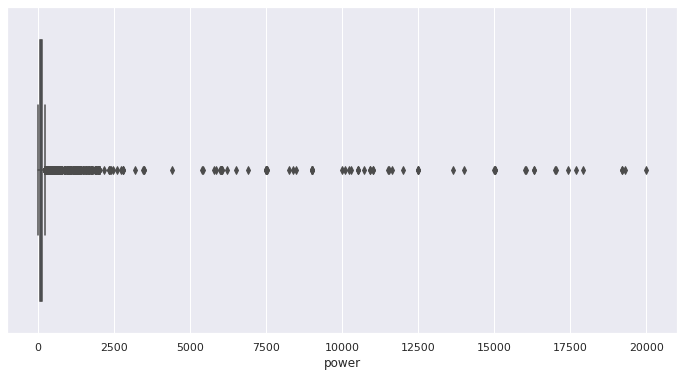

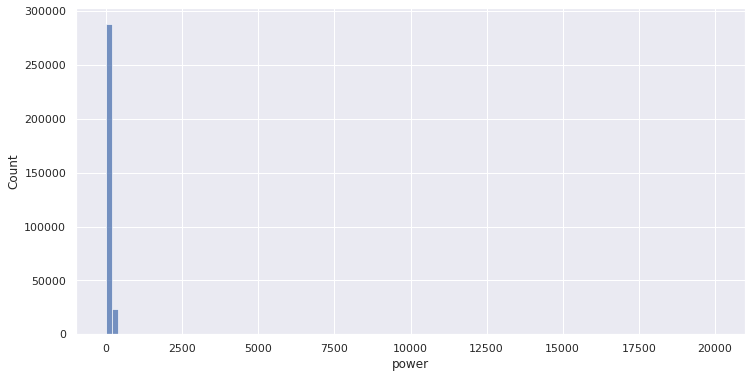

In [ ]:
data_info(data['power'])

Let's exclude zero values and values less than 50 hp, and divide all values above 2500 by 10 (consecutively, twice), because We consider such values to be typos/input errors.

In [ ]:
data.drop(data.loc[data['power']<=50].index, inplace=True)
data.loc[(data['power'] >= 2500), 'power'] = data['power'] / 10
data.loc[(data['power'] >= 2500), 'power'] = data['power'] / 10

In [ ]:
data.loc[(data['power'] >= 500), 'power'].count()

384

We see that after converting the “typos” there are only 384 lines of data left with a power of 500 hp or more. Let's exclude this data, because Due to their small number, such exclusion will not have an impact on the remaining data.

In [ ]:
data.drop(data.loc[data['power']>=500].index, inplace=True)

75.0     20080
150.0    13725
140.0    12542
101.0    12109
60.0     12096
         ...  
457.0        1
332.0        1
475.0        1
353.0        1
248.0        1
Name: power, Length: 366, dtype: int64

count    277080.000000
mean        125.097705
std          52.472601
min          51.000000
25%          86.000000
50%         116.000000
75%         150.000000
max         490.000000
Name: power, dtype: float64


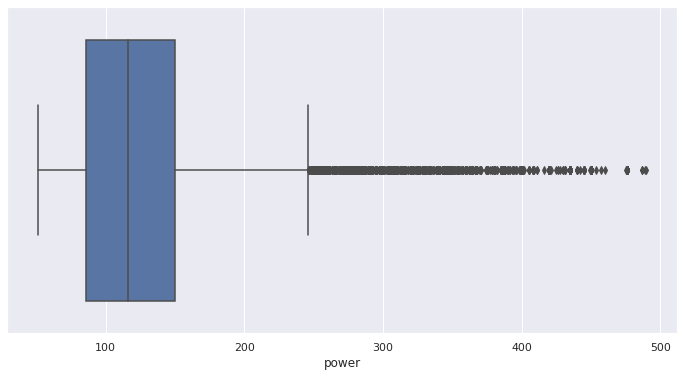

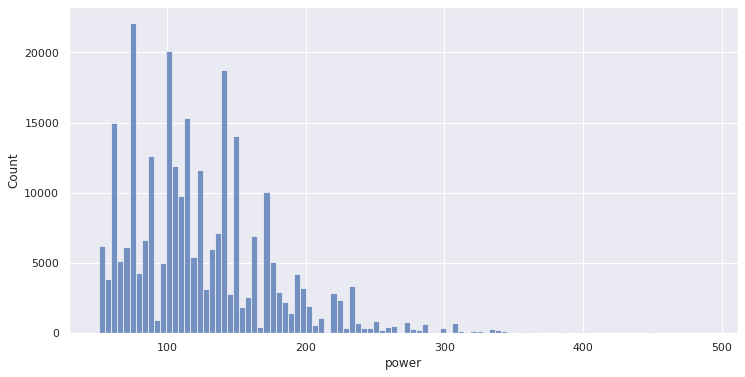

In [ ]:
data_info(data['power'])

### Column MODEL

In [ ]:
data['model'].value_counts()

other                 28786
golf                  23879
3er                   17030
a4                     8629
passat                 8592
                      ...  
i3                        4
serie_3                   3
rangerover                3
samara                    3
range_rover_evoque        2
Name: model, Length: 248, dtype: int64

In [ ]:
data['model'].describe()

count     277080
unique       248
top        other
freq       28786
Name: model, dtype: object

In [ ]:
data['model'].unique()

array(['other', 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'c4', 'civic', 'punto', 'e_klasse', 'clio',
       'kadett', 'one', 'fortwo', '1er', 'b_klasse', 'a8', 'jetta',
       'astra', 'c_klasse', 'micra', 'vito', 'sprinter', 'escort',
       'forester', 'xc_reihe', 'fiesta', 'scenic', 'a1', 'transporter',
       'focus', 'a4', 'tt', 'a6', 'jazz', 'polo', 'slk', '7er', 'combo',
       '80', '147', 'z_reihe', 'sportage', 'sorento', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'insignia', 'ka', 'almera', 'megane',
       'a3', 'caddy', 'corsa', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'lupo', 'berlingo', 'tiguan', 'i_reihe', '6_reihe',
       'panda', 'up', 'ceed', 'kangoo', '5_reihe', 'yeti', 'octavia',
       'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'matiz',
       'beetle', 'rio', 'touareg', 'logan', 'spider', 'omega', 'cuore',
       's_max', '

Let's unite range_rover and rangerover.

In [ ]:
data.loc[(data['model'] == 'rangerover'), 'model'] = 'range_rover'

In [ ]:
data['model'].value_counts()

other                 28786
golf                  23879
3er                   17030
a4                     8629
passat                 8592
                      ...  
serie_2                   5
i3                        4
serie_3                   3
samara                    3
range_rover_evoque        2
Name: model, Length: 247, dtype: int64

Let's shorten the list of models by combining models with less than 300 in the 'other' category. Total number of such lines of order 5%.

In [ ]:
other_models = data['model'].value_counts().to_frame().loc[data['model'].value_counts().to_frame()['model']<300].index
print(data['model'].value_counts().to_frame().loc[data['model'].value_counts().to_frame()['model']<300].sum())

for model in other_models:
    data.loc[data['model'] == model, 'model'] = 'other'

model    15555
dtype: int64


In [ ]:
data['model'].value_counts()

other      44341
golf       23879
3er        17030
a4          8629
passat      8592
           ...  
rio          312
100          310
sorento      307
kuga         306
accord       304
Name: model, Length: 127, dtype: int64

The list of models (categorical feature) was reduced by more than 2 times without a significant effect on the data.

### Column KILOMETER

150000    181627
125000     30214
100000     12246
90000       9953
80000       8796
70000       7623
60000       6664
50000       5562
40000       4401
30000       3747
20000       3107
5000        2293
10000        847
Name: kilometer, dtype: int64

count    277080.000000
mean     127858.109571
std       36813.269388
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


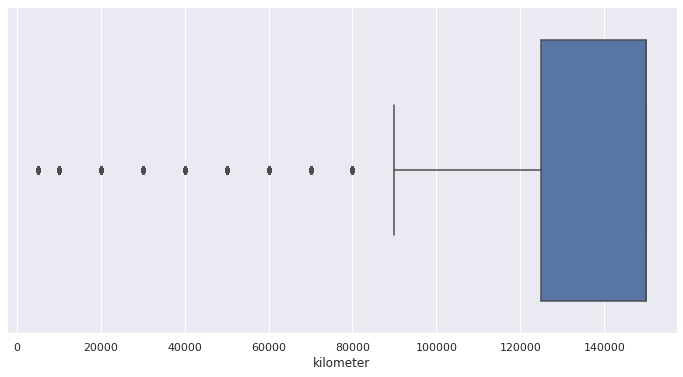

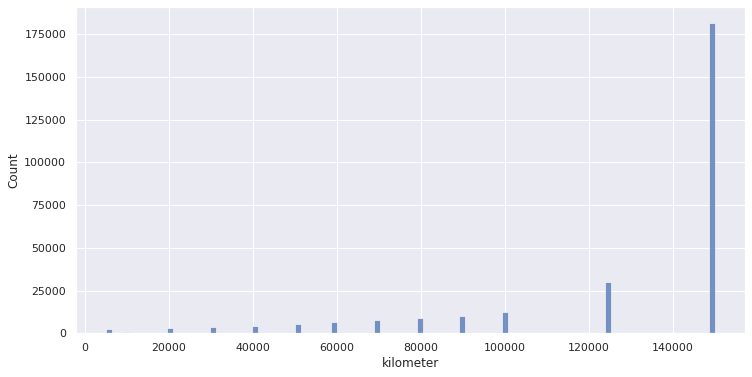

In [ ]:
data_info(data['kilometer'])

It is likely that mileage was initially entered/stored only in certain values (in 5,000 km increments) and therefore the values in this column can be considered categorical. The data does not require additional processing.

### Column FUEL_TYPE

In [ ]:
data['fuel_type'].value_counts()

petrol      168561
gasoline     87633
N\A          15506
lpg           4623
cng            478
hybrid         201
other           48
electric        30
Name: fuel_type, dtype: int64

In [ ]:
data['fuel_type'].describe()

count     277080
unique         8
top       petrol
freq      168561
Name: fuel_type, dtype: object

We combine the N\A values with which we replaced the gaps and 'other'. Otherwise, the column contains categorical data that does not require additional processing.

In [ ]:
data.loc[(data['fuel_type'] == 'N\A'), 'fuel_type'] = 'other'

In [ ]:
data['fuel_type'].value_counts()

petrol      168561
gasoline     87633
other        15554
lpg           4623
cng            478
hybrid         201
electric        30
Name: fuel_type, dtype: int64

### Column BRAND

In [ ]:
data['brand'].value_counts()

volkswagen        58847
bmw               32053
opel              28774
mercedes_benz     27566
audi              25437
ford              18164
renault           12486
peugeot            8745
fiat               6634
seat               5091
skoda              4929
mazda              4426
toyota             4042
citroen            3975
nissan             3722
smart              3571
hyundai            3067
mini               3019
volvo              2652
honda              2288
mitsubishi         2222
kia                2068
alfa_romeo         1875
suzuki             1815
sonstige_autos     1494
chevrolet          1469
chrysler           1109
dacia               820
porsche             616
jeep                590
subaru              566
daihatsu            470
land_rover          467
saab                446
jaguar              434
daewoo              333
lancia              328
rover               308
lada                156
trabant               6
Name: brand, dtype: int64

In [ ]:
data['brand'].describe()

count         277080
unique            40
top       volkswagen
freq           58847
Name: brand, dtype: object

Categorical feature - does not require modification.

### Column REPAIRED

In [ ]:
data['repaired'].value_counts()

no     255504
yes     21576
Name: repaired, dtype: int64

In [ ]:
data['repaired'].describe()

count     277080
unique         2
top           no
freq      255504
Name: repaired, dtype: object

Categorical feature - does not require modification.

Let's remove complete duplicate rows.

In [ ]:
data.duplicated().sum()

41710

FINAL parameters of the dataset for generating samples for machine learning models:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277080 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              277080 non-null  int64  
 1   vehicle_type       277080 non-null  object 
 2   registration_year  277080 non-null  int64  
 3   gearbox            277080 non-null  object 
 4   power              277080 non-null  float64
 5   model              277080 non-null  object 
 6   kilometer          277080 non-null  int64  
 7   fuel_type          277080 non-null  object 
 8   brand              277080 non-null  object 
 9   repaired           277080 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 23.3+ MB


**CONCLUSION for the section:**

The original historical vehicle performance data contained 354,369 rows and 16 columns, 5 columns contained missing data, and 6 columns did not contain vehicle performance information.

As a result of preprocessing:

- columns that did not contain data on vehicle characteristics were excluded;
- data processing was carried out in the data columns: omissions were excluded (replaced), values were corrected (combined with each other), anomalies (elections) were removed.

The data prepared for generating samples for training and testing machine learning models contains 277,080 rows and 10 columns - 9 feature columns and 1 target feature (price).


## Model training

We will create training, validation and test samples. Let's create a copy of these samples for the linear regression model.

In [ ]:
features = data.drop(['price'], axis=1)
target   = data['price']

features_train, features_test, target_train, target_test = tts(features, target, train_size=0.7, random_state=12345)

features_test, features_val, target_test, target_val = tts(features_test, target_test, train_size=0.5, random_state=12345)

In [ ]:
features_train_m_lr = features_train.copy()
features_val_m_lr  = features_val.copy()

Let's check the dimensions of the resulting samples.

In [ ]:
features_train.shape

(193956, 9)

In [ ]:
features_val.shape

(41562, 9)

In [ ]:
features_test.shape

(41562, 9)

Let's reduce categorical features to the category format so that they can be used in the LightGBM and CatBoost models.

In [ ]:
categorical = ['brand', 'model', 'vehicle_type', 'gearbox', 'fuel_type', 'kilometer', 'repaired']

features_train[categorical] = features_train[categorical].astype('category')
features_val[categorical] = features_val[categorical].astype('category')
features_test[categorical] = features_test[categorical].astype('category')

**Model LightGBM**

In [ ]:
model = lgb.LGBMRegressor(cat_feature=categorical)

In [ ]:
time_begin = time.time()
model.fit(features_train, target_train)
time_end = time.time()
time_fit = time_end - time_begin
print('Время обучения модели: ',round(time_fit,4))

Время обучения модели:  370.2477


In [ ]:
time_begin = time.time()
predict = model.predict(features_val)
time_end = time.time()
time_pred = time_end - time_begin
print('Время предсказания модели: ',round(time_pred,4))

Время предсказания модели:  0.4959


In [ ]:
rmse = round(mse(target_val, predict, squared=False),5)
print('RMSE модели: ', rmse)

RMSE модели:  1652.2277


**Model CatBoost**

In [ ]:
model = CatBoostRegressor(cat_features=categorical)

In [ ]:
time_begin = time.time()
model.fit(features_train, target_train)
time_end = time.time()
time_fit = time_end - time_begin

Learning rate set to 0.09411
0:	learn: 4313.1502164	total: 324ms	remaining: 5m 23s
1:	learn: 4067.7828961	total: 549ms	remaining: 4m 34s
2:	learn: 3847.2197714	total: 773ms	remaining: 4m 16s
3:	learn: 3654.4948625	total: 1.07s	remaining: 4m 26s
4:	learn: 3480.6868131	total: 1.27s	remaining: 4m 13s
5:	learn: 3330.9178088	total: 1.42s	remaining: 3m 55s
6:	learn: 3182.4501032	total: 1.71s	remaining: 4m 3s
7:	learn: 3061.6698384	total: 1.94s	remaining: 4m
8:	learn: 2949.9106670	total: 2.14s	remaining: 3m 55s
9:	learn: 2844.7331699	total: 2.35s	remaining: 3m 52s
10:	learn: 2757.5288351	total: 2.6s	remaining: 3m 53s
11:	learn: 2681.4618387	total: 2.83s	remaining: 3m 52s
12:	learn: 2609.7557448	total: 3.02s	remaining: 3m 49s
13:	learn: 2545.9350763	total: 3.22s	remaining: 3m 46s
14:	learn: 2487.2340256	total: 3.4s	remaining: 3m 43s
15:	learn: 2436.6165138	total: 3.63s	remaining: 3m 43s
16:	learn: 2388.4199816	total: 3.91s	remaining: 3m 45s
17:	learn: 2345.0233791	total: 4.1s	remaining: 3m 43s

In [ ]:
print('Время обучения модели: ',round(time_fit,4))

Время обучения модели:  212.7156


In [ ]:
time_begin = time.time()
predict = model.predict(features_val)
time_end = time.time()
time_pred = time_end - time_begin
print('Время предсказания модели: ',round(time_pred,4))

Время предсказания модели:  0.3936


In [ ]:
rmse = round(mse(target_val, predict, squared=False),5)
print('RMSE модели: ', rmse)

RMSE модели:  1625.38799


**Linear Regression Model**

In [ ]:
ohe_features_m_lr = features_train_m_lr.select_dtypes(include='object').columns.to_list()
print(ohe_features_m_lr)

num_features_m_lr = features_train_m_lr.select_dtypes(exclude='object').columns.to_list()
print(num_features_m_lr)

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
encoder_ohe.fit(features_train_m_lr[ohe_features_m_lr])

features_train_m_lr[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train_m_lr[ohe_features_m_lr])
features_train_m_lr = features_train_m_lr.drop(ohe_features_m_lr, axis=1)

features_val_m_lr[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_val_m_lr[ohe_features_m_lr])
features_val_m_lr = features_val_m_lr.drop(ohe_features_m_lr, axis=1)

scaler = StandardScaler()
features_train_m_lr[num_features_m_lr] = scaler.fit_transform(features_train_m_lr[num_features_m_lr])
features_val_m_lr[num_features_m_lr]   = scaler.transform(features_val_m_lr[num_features_m_lr])

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
['registration_year', 'power', 'kilometer']


In [ ]:
model = LinearRegression()

In [ ]:
time_begin = time.time()
model.fit(features_train_m_lr, target_train)
time_end = time.time()
time_fit = time_end - time_begin
print('Время обучения модели: ',round(time_fit,4))

Время обучения модели:  17.3587


In [ ]:
time_begin = time.time()
predict_m_lr = model.predict(features_val_m_lr)
time_end = time.time()
time_pred = time_end - time_begin
print('Время предсказания модели: ',round(time_pred,4))

Время предсказания модели:  0.1856


In [ ]:
rmse = round(mse(target_val, predict_m_lr, squared=False),5)
print('RMSE модели: ', rmse)

RMSE модели:  2629.708


**CONCLUSION for the section:**

The results turned out to be mixed: the best prediction time is demonstrated by the linear regression model, but it also shows the worst performance in terms of quality metrics. The value of the quality metric (RMSE) turned out to be greater than required, so we no longer consider this model.

The **CatBoost** model demonstrates better prediction time and quality metrics compared to LightGBM.

At the next stage of the project, by tuning (searching for optimal) hyperparameters of these models, we will improve the training and prediction time, while maintaining the value of the quality metric within the boundaries specified by the customer.

## Model Analysis

**Model LightGBM**

In [ ]:
model = lgb.LGBMRegressor(cat_feature=categorical, n_estimators=50, max_depth=10)

In [ ]:
time_begin = time.time()
model.fit(features_train, target_train)
time_end = time.time()
time_fit = time_end - time_begin
print('Время обучения модели: ',round(time_fit,4))

Время обучения модели:  184.8492


In [ ]:
time_begin = time.time()
predict = model.predict(features_test)
time_end = time.time()
time_pred = time_end - time_begin
print('Время предсказания модели: ',round(time_pred,4))

Время предсказания модели:  0.2187


In [ ]:
rmse = round(mse(target_test, predict, squared=False),5)
print('RMSE модели: ', rmse)

RMSE модели:  1718.72456


**Model CatBoost**

In [ ]:
model = CatBoostRegressor(cat_features=categorical, iterations=100, max_depth=10, random_seed=1)

In [ ]:
time_begin = time.time()
model.fit(features_train, target_train)
time_end = time.time()
time_fit = time_end - time_begin

Learning rate set to 0.5
0:	learn: 3189.5830608	total: 135ms	remaining: 13.3s
1:	learn: 2556.4805501	total: 272ms	remaining: 13.3s
2:	learn: 2277.0798612	total: 426ms	remaining: 13.8s
3:	learn: 2086.9681264	total: 551ms	remaining: 13.2s
4:	learn: 1996.6599199	total: 675ms	remaining: 12.8s
5:	learn: 1921.8254319	total: 800ms	remaining: 12.5s
6:	learn: 1891.7201335	total: 934ms	remaining: 12.4s
7:	learn: 1856.9005213	total: 1.06s	remaining: 12.2s
8:	learn: 1833.2278087	total: 1.19s	remaining: 12s
9:	learn: 1814.2596764	total: 1.31s	remaining: 11.8s
10:	learn: 1799.2255369	total: 1.44s	remaining: 11.7s
11:	learn: 1786.0577091	total: 1.56s	remaining: 11.5s
12:	learn: 1777.7571689	total: 1.69s	remaining: 11.3s
13:	learn: 1762.9785845	total: 1.8s	remaining: 11.1s
14:	learn: 1751.5521346	total: 2s	remaining: 11.3s
15:	learn: 1744.8180676	total: 2.12s	remaining: 11.1s
16:	learn: 1738.1111021	total: 2.24s	remaining: 10.9s
17:	learn: 1731.2125132	total: 2.38s	remaining: 10.8s
18:	learn: 1723.344

In [ ]:
print('Время обучения модели: ',round(time_fit,4))

Время обучения модели:  14.4719


In [ ]:
time_begin = time.time()
predict = model.predict(features_test)
time_end = time.time()
time_pred = time_end - time_begin
print('Время предсказания модели: ',round(time_pred,4))

Время предсказания модели:  0.0541


In [ ]:
rmse = round(mse(target_test, predict, squared=False),5)
print('RMSE модели: ', rmse)

RMSE модели:  1626.70161


**CONCLUSION for the section:**

As a result of selecting the hyperparameters of the LightGBM and CatBoost models, it was possible to significantly reduce the training and prediction time of these models, while maintaining the value of the quality metric below the level required by the customer.

Considering that the main qualitative characteristic of the model’s work was the ability to **quickly** obtain a price prediction (since this was precisely what was noted in the task as an advantage of the customer’s application), the final model was chosen as the **CatBoost** model, for which:


- Training time was: 12.9
- The prediction time on the test sample was: 0.049
- RMSE: 1 626

**PROJECT CONCLUSION:**

In accordance with the assignment, the customer, the service for selling used cars "Not a Bit, Not a Paint", while developing an application that provides the ability to **quickly** determine the cost of a car based on its technical parameters, set the task of developing a machine learning model that I would have predicted this price.

The characteristics of the model required by the customer: high speed of operation, quality metric RMSE no more than 2,500.

To develop the project, a dataset was provided with historical data on sales prices of used cars, including the technical characteristics of these cars.

The dataset contained 354,369 rows and 16 columns. The data contained gaps.

As a result of the data preprocessing, a dataset of 277,080 rows and 10 columns was prepared, containing no gaps, full of explicit and implicit duplicate rows, which was used for training and testing machine learning models.

3 machine learning models were studied: LightBRM, CatBoost and linear regression. Linear regression, although it showed better results in terms of training and prediction time, did not provide the required quality.

The LightBRM and CatBoost models were further analyzed in detail and, using the selection of hyperparameters, both training and prediction times were significantly reduced. The quality metric of these models in all cases was significantly lower than the threshold value specified by the customer.

As a result, the **CatBoost** model was chosen as the best model, which showed the following results:

- Training time was: 12.9 s.
- Prediction time on the test sample was: 0.049 s.
- RMSE: **1,626**. The resulting RMSE value is significantly lower than the threshold specified by the customer (2,500), and therefore the task can be considered **completely completed**.